In [1]:
!python -m pip -q install pandas openpyxl matplotlib

You should consider upgrading via the '/Users/schadem/.pyenv/versions/biertoto/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

Laden der Excel

In [3]:
df = pd.read_excel("data/Biertoto.xlsx")

alles was im 'Heim' einen leeren String oder keinen Wert hat, entfernen

In [4]:
df = df.dropna(subset=['Heim']).copy()

### team namen normalisieren damit man auch stats ueber teams fahren kann

habe dafuer die Teamnamen gezogen, dann verschiedene Schreibweisen aussortiert und in eine list geschrieben

In [5]:
len(df['Heim'].unique())

134

In [6]:
len(df['Gast'].unique())

91

wir sehen sehr viele variationen der Teamnamen

In [7]:
variations_team_names = df['Heim'].unique()

In [8]:
variations_team_names

array(['SC Freiburg', '1. FC Kaiserslautern', 'TSV 1860 München',
       'Karlsruher SC', 'Hamburger SV', 'Schalke 04',
       'Fortuna Düsseldorf', 'Bayer Leverkusen', 'KFC Uerdingen',
       '1. FC Köln', 'Eintracht Frankfurt', 'Bayern München',
       'VfB Stuttgart', 'Werder Bremen', 'FC St. Pauli',
       'Borussia Mönchengladbach', 'Hansa Rostock', 'Borussia Dortmund',
       'St. Pauli', 'Mönchengladbach', 'VFL Bochum', 'VFB Stuttgart',
       '1860 München', 'FC Schalke 04', 'Arminia Bielefeld',
       'MSV Duisburg', '1.FC Köln', 'Hertha BSC', 'VFL Wolfsburg',
       'Kaiserslautern', 'Bor. Dortmund', 'VfL Wolfsburg', 'VfL Bochum',
       '1. FC Nürnberg', 'Hertha BSC Berlin', 'TSV München 1860',
       'SSV Ulm', 'SpVgg Unterhaching', 'Bayern Muenchen',
       'VfB Stuttgart ', 'Bayern Muenchen ', 'MSV Duisburg ',
       'SpVgg Unterhaching ', 'Bayer Leverkusen ', 'Hamburger SV ',
       'Werder Bremen ', 'Arminia Bielefeld ', 'Hansa Rostock ',
       'Borussia Dortmund ', 'S

In [9]:
df_team_names = pd.read_csv('team_names.csv', quotechar="'", names=['name'])

In [10]:
df_team_names

,name
0,SC Freiburg
1,1. FC Kaiserslautern
2,TSV 1860 München
3,Karlsruher SC
4,Hamburger SV
5,Fortuna Düsseldorf
6,Bayer Leverkusen
7,KFC Uerdingen
8,1. FC Köln
9,Eintracht Frankfurt


In [11]:
from difflib import SequenceMatcher as sm
import difflib

In [12]:
normalized_team_names = df_team_names['name'].tolist()

hiermit checke ich ob das mapping funktioniert - zur manuellen probe mal ausgeben
Ich nutze difflib mit einer Funktion die versucht einen 'passenden' string zu finden

In [13]:
for x in variations_team_names:
    print(f"{x}, {difflib.get_close_matches(x, normalized_team_names)}")    

SC Freiburg, ['SC Freiburg', 'MSV Duisburg', 'MSV Duisburg']
1. FC Kaiserslautern, ['1. FC Kaiserslautern', '1. FC Köln']
TSV 1860 München, ['TSV 1860 München']
Karlsruher SC, ['Karlsruher SC']
Hamburger SV, ['Hamburger SV']
Schalke 04, ['FC Schalke 04']
Fortuna Düsseldorf, ['Fortuna Düsseldorf']
Bayer Leverkusen, ['Bayer Leverkusen']
KFC Uerdingen, ['KFC Uerdingen']
1. FC Köln, ['1. FC Köln', '1. FC Kaiserslautern']
Eintracht Frankfurt, ['Eintracht Frankfurt']
Bayern München, ['Bayern München']
VfB Stuttgart, ['VfB Stuttgart']
Werder Bremen, ['Werder Bremen']
FC St. Pauli, ['FC St. Pauli']
Borussia Mönchengladbach, ['Borussia Mönchengladbach']
Hansa Rostock, ['Hansa Rostock']
Borussia Dortmund, ['Borussia Dortmund']
St. Pauli, ['FC St. Pauli']
Mönchengladbach, ['Borussia Mönchengladbach']
VFL Bochum, ['VFL Bochum']
VFB Stuttgart, ['VfB Stuttgart']
1860 München, ['TSV 1860 München', 'Bayern München']
FC Schalke 04, ['FC Schalke 04']
Arminia Bielefeld, ['Arminia Bielefeld']
MSV Duisburg

sieht ok aus, der erste Vorschlag scheint zu passen. Also ersetzte ich jetzt mal alle

In [14]:
# das hier ist zwar nicht effizient weil wir die Antwort cachen koennten, egal erstmal
def normalize_team_names(team_name):
    return difflib.get_close_matches(team_name, normalized_team_names)[0]

In [15]:
df['Heim'] = df.apply(lambda row:normalize_team_names(row['Heim']), axis=1)

In [16]:
len(df['Heim'].unique())

40

In [17]:
df['Gast'] = df.apply(lambda row:normalize_team_names(row['Gast']), axis=1)

In [18]:
len(df['Gast'].unique())

40

Function um spaeter zu speichern ob ein Ergebnis Heimsieg, Auswaertssieg oder Untentschieden ist

In [19]:
def home_draw_away_generic(home_goals, away_goals)->str:
    """
    A = away team won
    H = home team won
    D = draw
    """
    diff = home_goals - away_goals
    if pd.isnull(home_goals) or pd.isnull(away_goals):
        return np.nan
    if diff < 0:
        return 'A'
    elif diff > 0:
        return 'H'
    else:
        return 'D'


Fuer das Spielergebnis berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [20]:
def home_draw_away(row):
    return home_draw_away_generic(row['Htore'], row['Gtore'])
    

Fuer das Uwe-Tipp berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [21]:
def home_draw_away_uwe(row):
    return home_draw_away_generic(row['UHT'], row['UGT'])

Fuer das Schadix-Tipp berechnen od Heim- oder Auswaertssieg oder Untenschieden

In [22]:
def home_draw_away_schadix(row):
    return home_draw_away_generic(row['SHT'], row['SGT'])

Funktion um zu checken ob 2 Ergebnisse identisch sind

In [23]:
def match_result_generic(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    if pd.isnull(home_goals_1) or pd.isnull(away_goals_1) or pd.isnull(home_goals_2) or pd.isnull(away_goals_2):
        return False
    try:
        return int(home_goals_1) == int(home_goals_2) and int(away_goals_1) == int(away_goals_2)
    except ValueError:
        return False

    

Funktion um zu checken ob 2 Ergebnisse die gleiche Tordifferenz haben

In [24]:
def same_goal_difference(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    if pd.isnull(home_goals_1) or pd.isnull(away_goals_1) or pd.isnull(home_goals_2) or pd.isnull(away_goals_2):
        return False
    try:
        return int(home_goals_1) - int(away_goals_1) == int(home_goals_2) - int(away_goals_2)
    except ValueError:
        return False

    

Funktion checkt ob Uwe die gleiche Tordifferenz hat wie das Spielergebnis

In [25]:
def same_goal_difference_uwe(row)->bool:
    return same_goal_difference(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Schadix die gleiche Tordifferenz hat wie das Spielergebnis

In [26]:
def same_goal_difference_schadix(row)->bool:
    return same_goal_difference(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'],
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Uwe das gleiche Ergebnis getippt hat wie das Spielergebnis

In [27]:
def same_result_uwe(row)->bool:
    return match_result_generic(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Funktion checkt ob Schadix das gleiche Ergebnis getippt hat wie das Spielergebnis

In [28]:
def same_result_schadix(row)->bool:
    return match_result_generic(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

Fuer die Berechnungen und vor allem die Sortierung der Ergebnisse ist es einfacher wenn die Jahrezahlen komplett sind, also basteln wir das mal

In [29]:
def get_year(row)->int:
    """add 19 to string with split on / in case of 9x else add 20"""
    saison = row['Saison']
    first_year, second_year = saison.split('/')
    first_year = first_year.strip()
    if first_year.startswith('9'):
        return int("19"+first_year)
    else:
        return int("20"+first_year)
        

Punkte berechnen basierend auf der Biertoto Berechnung

In [30]:
def calculate_points_generic_historic(tendency:bool=False, 
                             same_goal_difference:bool=False, 
                             same_result:bool=False,
                            draw:bool=False)->int:
    result_points = 0
    if tendency:
        result_points += 1
    if same_goal_difference and not draw:
        result_points += 1
    if same_result:
        if not draw:
            result_points += 1
        else:
            result_points += 2
    return result_points
    

ein paar Tests

In [31]:
# Test historic calculation
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=False, draw=True) == 1 
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=True, draw=True) == 3 
assert calculate_points_generic_historic(tendency=False, same_goal_difference=False, same_result=False, draw=True) == 0
assert calculate_points_generic_historic(tendency=True, same_goal_difference=True, same_result=False, draw=False) == 2

Punkte berechnen basierend auf der Kicktipp Berechnung

In [32]:
def calculate_points_generic_kicktipp(tendency:bool=False, 
                             same_goal_difference:bool=False, 
                             same_result:bool=False,
                            draw:bool=False)->int:
    result_points = 0
    if tendency:
        result_points += 2
    if same_goal_difference and not draw:
        result_points += 1
    if same_result:
        if not draw:
            result_points += 1
        else:
            result_points += 1
    return result_points
    

und die ganzen Funktionen ausfuehren und als Columns in dem DataFrame speichern

In [33]:
df['year'] = df.apply(get_year, axis=1)

In [34]:
df['tendenz'] = df.apply(home_draw_away, axis=1)

In [35]:
df['tendenz_uwe'] = df.apply(home_draw_away_uwe, axis=1)

In [36]:
df['tendenz_schadix'] = df.apply(home_draw_away_schadix, axis=1)

In [37]:
df['correct_tendenz_uwe'] = df['tendenz'] == df['tendenz_uwe']

In [38]:
df['correct_tendenz_schadix'] = df['tendenz'] == df['tendenz_schadix']

In [39]:
df['same_goal_uwe'] = df.apply(same_goal_difference_uwe, axis=1)

In [40]:
df['same_goal_schadix'] = df.apply(same_goal_difference_schadix, axis=1)

In [41]:
df['same_result_uwe'] = df.apply(same_result_uwe, axis=1)

In [42]:
df['same_result_schadix'] = df.apply(same_result_schadix, axis=1)

In [43]:
df['result_match_uwe_schadix'] = df.apply(lambda row: match_result_generic(row['UHT'], row['UGT'], row['SHT'], row['SGT']), axis=1)

In [44]:
df['points_uwe'] = df.apply(lambda row: calculate_points_generic_kicktipp(tendency=row['tendenz_uwe']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_uwe'],
                                                                 same_result=row['same_result_uwe'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [45]:
df['points_uwe_historic'] = df.apply(lambda row: calculate_points_generic_historic(tendency=row['tendenz_uwe']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_uwe'],
                                                                 same_result=row['same_result_uwe'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [46]:
df['points_schadix'] = df.apply(lambda row: calculate_points_generic_kicktipp(tendency=row['tendenz_schadix']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_schadix'],
                                                                 same_result=row['same_result_schadix'],
                                                                 draw=row['SHT']==row['SGT']
                                                                ), axis=1)

In [47]:
df['points_schadix_historic'] = df.apply(lambda row: calculate_points_generic_historic(tendency=row['tendenz_schadix']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_schadix'],
                                                                 same_result=row['same_result_schadix'],
                                                                 draw=row['SHT']==row['SGT']                                                                                       
                                                                ), axis=1)

Einen String vom Ergebnis erzeugen um spaeter darueber Statistiken zu fahren, machen wir dann fuer das eigentliche Ergebnis, fuer das von Uwe und Schadix

In [48]:
def create_result_string(home_goals, guest_goals):
    if pd.isnull(home_goals) or pd.isnull(guest_goals):
        return np.nan
    else:
        return str(int(home_goals))+":"+str(int(guest_goals))
    

In [49]:
df['result_string']=df.apply(lambda row:str(int(row['Htore']))+":"+str(int(row['Gtore'])), axis=1)

In [50]:
df['result_string_uwe']=df.apply(lambda row: create_result_string(row['UHT'], row['UGT']), axis=1)

In [51]:
df['result_string_schadix']=df.apply(lambda row: create_result_string(row['SHT'], row['SGT']), axis=1)

Einmal alle column-namen ausgeben, nur mal so

In [52]:
df.columns

Index(['Heim', 'Gast', 'Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT',
       'Spieltag', 'Saison', 'Unnamed: 10', 'UP', 'SP', 'Spieltag.1',
       'Unnamed: 14', 'year', 'tendenz', 'tendenz_uwe', 'tendenz_schadix',
       'correct_tendenz_uwe', 'correct_tendenz_schadix', 'same_goal_uwe',
       'same_goal_schadix', 'same_result_uwe', 'same_result_schadix',
       'result_match_uwe_schadix', 'points_uwe', 'points_uwe_historic',
       'points_schadix', 'points_schadix_historic', 'result_string',
       'result_string_uwe', 'result_string_schadix'],
      dtype='object')

Wie haeufig hat Schadix nicht getipp?

In [53]:
df[df['SHT'].isna()]

,Heim,Gast,Htore,Gtore,UHT,UGT,SHT,SGT,Spieltag,Saison,...,same_result_uwe,same_result_schadix,result_match_uwe_schadix,points_uwe,points_uwe_historic,points_schadix,points_schadix_historic,result_string,result_string_uwe,result_string_schadix
1620,Energie Cottbus,VfL Wolfsburg,0.0,0.0,3.0,1.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,0:0,3:1,NaN
1621,Eintracht Frankfurt,Bayer Leverkusen,1.0,3.0,0.0,3.0,NaN,NaN,28,00/01,...,False,False,False,2,1,0,0,1:3,0:3,NaN
1622,1. FC Köln,SpVgg Unterhaching,1.0,1.0,4.0,1.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,1:1,4:1,NaN
1623,TSV 1860 München,VFL Bochum,2.0,4.0,3.0,0.0,NaN,NaN,28,00/01,...,False,False,False,0,0,0,0,2:4,3:0,NaN
1624,Werder Bremen,Hertha BSC Berlin,3.0,1.0,2.0,0.0,NaN,NaN,28,00/01,...,False,False,False,3,2,0,0,3:1,2:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7191,Bayern München,Hertha BSC Berlin,2.0,2.0,2.0,0.0,NaN,NaN,1,19/20,...,False,False,False,0,0,0,0,2:2,2:0,NaN
7758,1. FC Köln,RB Leipzig,2.0,1.0,1.0,3.0,NaN,NaN,30,20/21,...,False,False,False,0,0,0,0,2:1,1:3,NaN
7759,Bayern München,Bayer Leverkusen,2.0,0.0,3.0,1.0,NaN,NaN,30,20/21,...,False,False,False,3,2,0,0,2:0,3:1,NaN
7760,Eintracht Frankfurt,FC Augsburg,2.0,0.0,2.0,1.0,NaN,NaN,30,20/21,...,False,False,False,2,1,0,0,2:0,2:1,NaN


Gruppiere in Jahre und summiere die Punkte fuer Uwe und Schadix auf und speichere in einen neuen DataFrame

## Kicktipp Calculation

In [54]:
df_points_sum = df.groupby('year').sum(['points_schadix', 'points_uwe'])[['points_schadix', 'points_uwe']]

In [55]:
df_points_sum

,points_schadix,points_uwe
year,,
1995,124,141
1996,345,367
1997,316,348
1998,321,383
1999,353,362
2000,296,366
2001,327,382
2002,311,360
2003,407,355


### Gesamtpunkte im Laufe der Zeit

Jetzt mal die kummulierten Punkte in einer Grafik darstellen

In [56]:
df_sum_points = df_points_sum.cumsum()

<AxesSubplot: xlabel='year'>

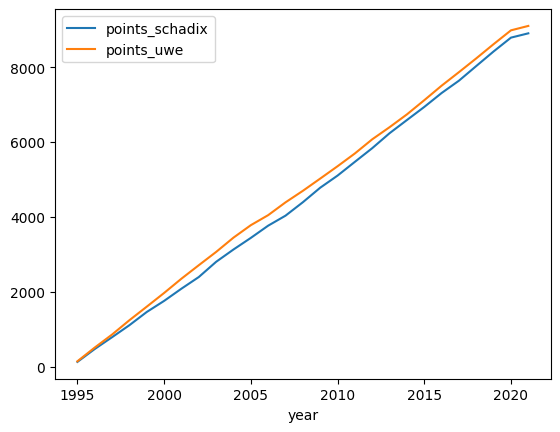

In [57]:
df_points_sum.cumsum().plot()

### Gesamtpunke-Abstand Uwe-Schadix

<AxesSubplot: xlabel='year'>

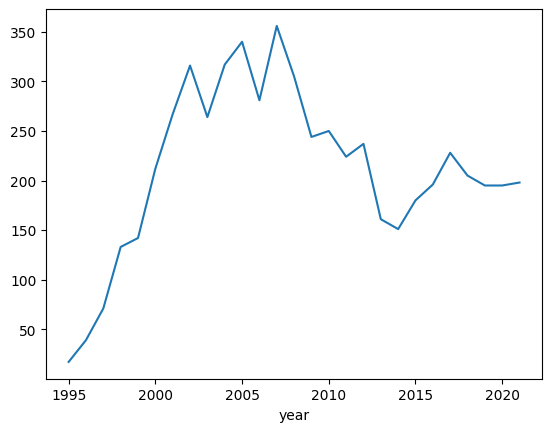

In [58]:
df_sum_points['point_difference'] = df_sum_points['points_uwe'] - df_sum_points['points_schadix']
df_sum_points['point_difference'].plot()

## Historische Kalkulation

In [59]:
df_points_sum = df.groupby('year').sum(['points_schadix_historic', 'points_uwe_historic'])[['points_schadix_historic', 'points_uwe_historic']]

In [60]:
df_points_sum

,points_schadix_historic,points_uwe_historic
year,,
1995,72,85
1996,205,222
1997,197,217
1998,196,237
1999,222,219
2000,177,219
2001,192,226
2002,187,220
2003,250,211


### Gesamtpunkte im Laufe der Zeit

Jetzt mal die kummulierten Punkte in einer Grafik darstellen

In [61]:
df_sum_points = df_points_sum.cumsum()

<AxesSubplot: xlabel='year'>

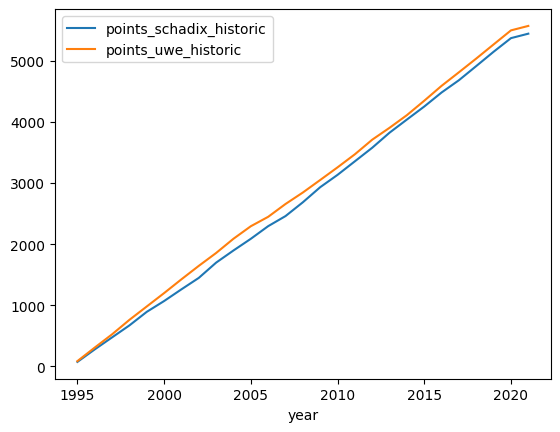

In [62]:
df_points_sum.cumsum().plot()

### Gesamtpunke-Abstand Uwe-Schadix

<AxesSubplot: xlabel='year'>

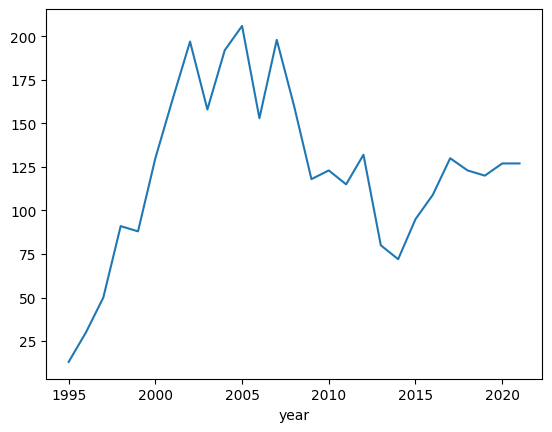

In [63]:
df_sum_points['point_difference'] = df_sum_points['points_uwe_historic'] - df_sum_points['points_schadix_historic']
df_sum_points['point_difference'].plot()

### Wie haeufig gleiche Ergebnisse getippt im Laufe der Zeit

Das [:1] am Ende nimmt die aktuelle Saison raus, weil da noch nicht so viele Ergebnisse vorhanden sind und die Statistik dann nach unten gerissen wird. 

In [64]:
df_same_tipps_over_time = df.groupby('year').sum(['result_match_uwe_schadix'])[['result_match_uwe_schadix']][:-1]

damits nicht so eckig aussieht, machen wir ein smoothing des graphen ueber die mean letzten 10 Ergenisse 

In [65]:
df_same_tipps_over_time['avg_10'] = df_same_tipps_over_time.result_match_uwe_schadix.rolling(10, min_periods=0).mean()

<AxesSubplot: xlabel='year'>

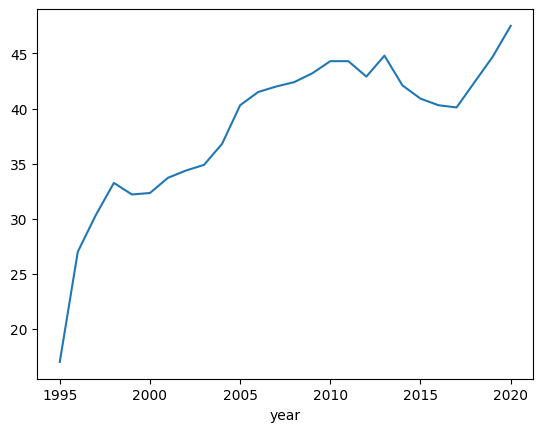

In [66]:
df_same_tipps_over_time['avg_10'].plot()

Wie haeufig haben wir die gleiche Tendenz getipp im Laufe der Zeit?

In [67]:
df['same_tendenz_uwe_schadix'] = df.apply(lambda row: row['tendenz_uwe'] == row['tendenz_schadix'], axis=1)

In [68]:
df_same_tendenz_uwe_schadix = df.groupby('year').sum(['same_tendenz_uwe_schadix'])[['same_tendenz_uwe_schadix']][:-1]

damits nicht so eckig aussieht, machen wir ein smoothing des graphen ueber die mean letzten 10 Ergenisse 

In [69]:
df_same_tendenz_uwe_schadix['avg_10'] = df_same_tendenz_uwe_schadix.same_tendenz_uwe_schadix.rolling(10, min_periods=0).mean()

<AxesSubplot: xlabel='year'>

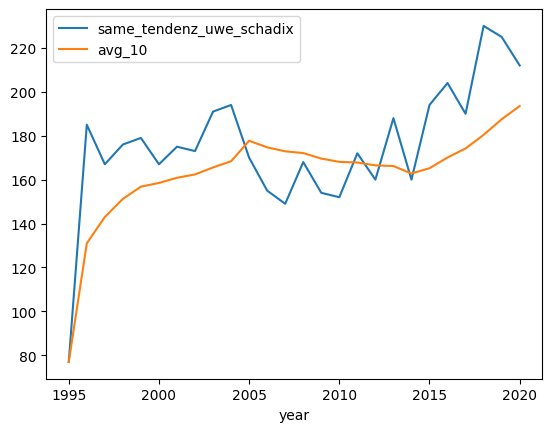

In [70]:
df_same_tendenz_uwe_schadix.plot()

Probability of results

In [71]:
results_count = df.groupby('result_string')['result_string'].count().sort_values()
results_sum = results_count.sum()
df_results_count = pd.DataFrame(index=results_count.index, data=results_count.values, columns=['count'])
# results_count['probability_result'] = results_count['']
df_results_count['probability_result'] = df_results_count['count'] / results_sum

### Wahrscheinlichkeit fuer ein 0:0

In [72]:
zero_draw_probability = float(df_results_count[df_results_count.index == '0:0']['probability_result'])
print(f"Wahrscheinlichkeit fuer ein 0:0 = {zero_draw_probability*100:0.2f} %")

Wahrscheinlichkeit fuer ein 0:0 = 6.71 %


### Es gab in den letzten 25 Jahren kein 5:5...

In [73]:
a = df_results_count[df_results_count.index == '5:5']['probability_result']
len(a)

0

In [74]:
def get_probability_number(result_string):
    # print(result_string)
    if pd.isnull(result_string):
        return np.nan
    try:
        prob = df_results_count[df_results_count.index == result_string]['probability_result']
        if len(prob) == 0:
            return 1
        return 1 - float(prob)
    except KeyError as ke:
        return np.nan


In [75]:
df['probability_count_uwe'] = df.apply(lambda row:get_probability_number(row['result_string_uwe']), axis=1)

In [76]:
df['probability_count_schadix'] = df.apply(lambda row:get_probability_number(row['result_string_schadix']), axis=1)

In [77]:
print(f"Uwe: {df['probability_count_uwe'].sum()}")
print(f"Schadix: {df['probability_count_schadix'].sum()}")

Uwe: 7331.625364246801
Schadix: 7170.185100722159


Probability of results with tips combined

Mit welchem Ergebnis haben wir die meisten Punkte gesammelt

In [78]:
df.groupby("result_string_schadix")['points_schadix'].sum(['points_schadix']).sort_values(ascending=False)

result_string_schadix
2:0    1628
2:1    1379
1:0    1195
3:1     892
3:0     590
1:1     573
0:2     571
1:2     449
0:1     419
1:3     262
2:2     203
0:3     196
3:2     137
4:0      87
0:0      85
4:1      61
2:3      58
0:4      38
1:4      20
5:1      15
4:2      10
3:3       8
4:3       8
1:5       6
5:0       4
2:4       4
6:1       3
1:8       2
0:5       2
6:2       2
3:5       0
3:4       0
5:5       0
6:0       0
Name: points_schadix, dtype: int64

In [79]:
df.groupby("result_string_uwe")['points_uwe'].sum(['points_uwe']).sort_values(ascending=False)

result_string_uwe
2:0    1556
2:1    1552
3:1    1104
1:1     821
3:0     737
1:2     686
1:3     616
0:2     556
1:0     537
2:2     240
0:3     165
0:1     136
4:0     107
0:0      84
4:1      83
3:2      39
1:4      38
0:4      20
4:2      16
2:4       6
2:3       4
0:5       2
1:5       0
5:0       0
5:1       0
5:2       0
5:4       0
Name: points_uwe, dtype: int64

#### max points spieltag

In [80]:
df_points_spieltag = df.groupby(['year', 'Spieltag']).sum(['points_uwe', 'points_schadix'])

In [81]:
df_points_spieltag

Htore  Gtore   UHT   UGT   SHT   SGT  Unnamed: 10    UP    SP  \
year Spieltag                                                                  
1995 18         12.0    8.0  11.0  15.0   9.0  12.0         45.0   3.0   3.0   
     19         11.0   12.0  20.0   4.0  14.0   9.0        126.0   5.0   2.0   
     20         10.0   11.0  14.0  14.0  14.0   5.0        207.0   4.0   3.0   
     21         14.0    7.0  16.0   5.0  11.0  11.0        288.0   6.0  10.0   
     22         14.0    8.0  15.0   8.0  17.0   8.0        369.0   6.0   5.0   
...              ...    ...   ...   ...   ...   ...          ...   ...   ...   
2021 6          17.0    5.0  13.0  14.0  13.0  11.0      70677.0   6.0   6.0   
     7          15.0   16.0  18.0  12.0  17.0   9.0      70758.0   5.0   5.0   
     8          15.0   12.0  15.0   8.0  17.0   8.0      70839.0   5.0   4.0   
     9          19.0   10.0  15.0  14.0  13.0  11.0      70920.0   7.0   9.0   
     10         17.0   13.0  17.0  11.0  14.0  12.0      71001.0  11.0  16.0   

               Spieltag.1  ...  same_result_uwe  same_result_schadix  \
year Spieltag              ...                                         
1995 18               3.0  ...                0                    0   
     19               5.0  ...                1                    0   
     20               4.0  ...                1                    1   
     21               6.0  ...                0                    2   
     22               6.0  ...                0                    0   
...                   ...  ...              ...                  ...   
2021 6                6.0  ...                0                    0   
     7                5.0  ...                0                    0   
     8                5.0  ...                1                    1   
     9                7.0  ...                1                    2   
     10              11.0  ...                1                    4   

               result_match_uwe_schadix  points_uwe  points_uwe_historic  \
year Spieltag                                                              
1995 18                               2           5                    3   
     19                               0           8                    5   
     20                               1           6                    4   
     21                               1          11                    6   
     22                               3          11                    7   
...                                 ...         ...                  ...   
2021 6                                2          11                    6   
     7                                4           9                    5   
     8                                0           8                    5   
     9                                4          11                    7   
     10                               2          17                   11   

               points_schadix  points_schadix_historic  \
year Spieltag                                            
1995 18                     6                        3   
     19                     4                        2   
     20                     4                        3   
     21                    15                       10   
     22                     9                        5   
...                       ...                      ...   
2021 6                     11                        6   
     7                      9                        5   
     8                      6                        4   
     9                     13                        9   
     10                    22                       16   

               same_tendenz_uwe_schadix  probability_count_uwe  \
year Spieltag                                                    
1995 18                               6               8.450652   
     19                               5               8.327885   
     20                      

In [82]:
df_points_spieltag.columns

Index(['Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT', 'Unnamed: 10', 'UP', 'SP',
       'Spieltag.1', 'Unnamed: 14', 'correct_tendenz_uwe',
       'correct_tendenz_schadix', 'same_goal_uwe', 'same_goal_schadix',
       'same_result_uwe', 'same_result_schadix', 'result_match_uwe_schadix',
       'points_uwe', 'points_uwe_historic', 'points_schadix',
       'points_schadix_historic', 'same_tendenz_uwe_schadix',
       'probability_count_uwe', 'probability_count_schadix'],
      dtype='object')

## Schadix Spieltag mit den meisten Punkten

In [83]:
df_points_spieltag[df_points_spieltag['points_schadix'] == df_points_spieltag['points_schadix'].max()]['points_schadix']

year  Spieltag
2009  9           28
Name: points_schadix, dtype: int64

## Uwe Spieltag mit den meisten Punkten

In [85]:
df_points_spieltag[df_points_spieltag['points_uwe'] == df_points_spieltag['points_uwe'].max()]['points_uwe']

year  Spieltag
2000  2           23
2004  22          23
Name: points_uwe, dtype: int64

## Lucky? 

Wie hauefig einen Spieltag verloren selbst wenn mehr Tendenzen correct waren

In [86]:
df.columns

Index(['Heim', 'Gast', 'Htore', 'Gtore', 'UHT', 'UGT', 'SHT', 'SGT',
       'Spieltag', 'Saison', 'Unnamed: 10', 'UP', 'SP', 'Spieltag.1',
       'Unnamed: 14', 'year', 'tendenz', 'tendenz_uwe', 'tendenz_schadix',
       'correct_tendenz_uwe', 'correct_tendenz_schadix', 'same_goal_uwe',
       'same_goal_schadix', 'same_result_uwe', 'same_result_schadix',
       'result_match_uwe_schadix', 'points_uwe', 'points_uwe_historic',
       'points_schadix', 'points_schadix_historic', 'result_string',
       'result_string_uwe', 'result_string_schadix',
       'same_tendenz_uwe_schadix', 'probability_count_uwe',
       'probability_count_schadix'],
      dtype='object')

In [87]:
df_tendenz_points = df.groupby(['year', 'Spieltag']).sum(['correct_tendenz_uwe', 
                                                           'correct_tendenz_schadix', 
                                                           'points_uwe', 
                                                           'points_schadix'])

In [88]:
df_tendenz_points['correct_tendenz_uwe']

year  Spieltag
1995  18          2
      19          3
      20          2
      21          5
      22          4
                 ..
2021  6           5
      7           4
      8           3
      9           4
      10          6
Name: correct_tendenz_uwe, Length: 877, dtype: int64

In [89]:
df_tendenz_points_uwe = df_tendenz_points[ (df_tendenz_points['correct_tendenz_uwe'] 
                    > df_tendenz_points['correct_tendenz_schadix']) & 
                  (df_tendenz_points['points_uwe'] 
                   < df_tendenz_points['points_schadix']) ][['correct_tendenz_uwe', 'correct_tendenz_schadix', 'points_uwe', 'points_schadix']]

In [90]:
df_tendenz_points_schadix = df_tendenz_points[ (df_tendenz_points['correct_tendenz_schadix'] 
                    > df_tendenz_points['correct_tendenz_uwe']) & 
                  (df_tendenz_points['points_schadix'] 
                   < df_tendenz_points['points_uwe']) ][['correct_tendenz_uwe', 'correct_tendenz_schadix', 'points_uwe', 'points_schadix']]

In [91]:
print(f"""Schadix hat {len(df_tendenz_points_schadix)} mal den Spieltag verloren, obwohl mehr Tendenzen richtig getippt waren.""")
print(f"""Uwe hat {len(df_tendenz_points_uwe)} mal den Spieltag verloren, obwohl mehr Tendenzen richtig getippt waren.""")

Schadix hat 10 mal den Spieltag verloren, obwohl mehr Tendenzen richtig getippt waren.
Uwe hat 7 mal den Spieltag verloren, obwohl mehr Tendenzen richtig getippt waren.


### Ganz klar, Uwe hat mehr Glueck wie es scheint... ;-)

Wie haeufig vergessen zu tippen (gesamt und ueber zeit)

Mit welchen Mannschaften die meisten Punkte?

Gegen den Tabellenstand getippt? (Getippt dass die Mannschaft mit der hoeheren Tabellenposition-zahl gewinnt)

Spieltagsiege (insgesamt, ueber-Zeit)

In [92]:
df1 = df.groupby(['Heim']).sum(['points_uwe', 'points_schadix', 'points_schadix_historic', 'points_uwe_historic'])[['points_uwe', 'points_schadix', 'points_uwe_historic', 'points_schadix_historic']]
df1 = df1.rename(columns={'Heim':'Team'})

In [93]:
df2 = df.groupby(['Gast']).sum(['points_uwe', 'points_schadix', 'points_schadix_historic', 'points_uwe_historic'])[['points_uwe', 'points_schadix', 'points_uwe_historic', 'points_schadix_historic']]
df2 = df2.rename(columns={'Gast':'Team'})

In [94]:
#df_points_per_team = pd.concat([df1, df2]).sum().reset_index()
df_points_per_team = pd.concat([df1, df2])
# df_points_per_team = pd.merge(df1, df2)

In [95]:
df_points_per_team = df_points_per_team.groupby(df_points_per_team.index).sum()

In [96]:
df_points_per_team['uwe_schadix_diff'] = df_points_per_team['points_uwe_historic'] - df_points_per_team['points_schadix_historic']

'uwe_schadix_diff' 

* ist negativ when Schadix mehr Punkte mit der Mannschaft gemacht hat als Uwe
* ist positiv wenn Uwe mehr Punkte mit der Mannschaft gemacht hat


In [97]:
df_points_per_team.sort_values(['uwe_schadix_diff'])

,points_uwe,points_schadix,points_uwe_historic,points_schadix_historic,uwe_schadix_diff
Borussia Mönchengladbach,875,930,540,576,-36
Werder Bremen,885,932,531,565,-34
Hannover 96,583,623,352,384,-32
Hamburger SV,798,831,491,521,-30
1. FC Kaiserslautern,421,453,248,277,-29
1. FC Nürnberg,478,515,290,319,-29
VFL Bochum,431,442,260,279,-19
FSV Mainz 05,412,434,252,266,-14
Eintr. Braunschweig,37,50,23,32,-9
FC Schalke 04,937,963,578,586,-8


Welche Mannschaft am haeufigsten auf Sieg getippt?

In [98]:
pd.set_option("display.max_columns", None)

In [99]:
win_teams_heim = df[df.tendenz == 'H']['Heim']
win_teams_heim = win_teams_heim.rename('Team')
win_teams_gast = df[df.tendenz == 'A']['Gast']
win_teams_gast = win_teams_gast.rename('Team')
win_teams = win_teams_heim.append(win_teams_gast)

/var/folders/s4/y_t_mj094c95t80n023c9wym0000gr/T/ipykernel_18476/2224135771.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  win_teams = win_teams_heim.append(win_teams_gast)


So haeufig haben die teams gewonnen

In [100]:
df_win_teams = win_teams.value_counts()

In [101]:
df_win_teams

Bayern München              586
Borussia Dortmund           440
Bayer Leverkusen            423
FC Schalke 04               362
Werder Bremen               347
VfL Wolfsburg               318
VfB Stuttgart               313
Hertha BSC Berlin           279
Hamburger SV                277
Borussia Mönchengladbach    272
Eintracht Frankfurt         214
SC Freiburg                 193
Hannover 96                 172
TSG Hoffenheim              160
1. FC Köln                  159
1. FC Kaiserslautern        144
FSV Mainz 05                131
1. FC Nürnberg              117
VFL Bochum                  114
Hansa Rostock               108
TSV 1860 München            103
FC Augsburg                 103
RB Leipzig                   95
Arminia Bielefeld            87
Energie Cottbus              56
MSV Duisburg                 54
Karlsruher SC                49
1. FSV Mainz 05              43
Fortuna Düsseldorf           41
1. FC Union Berlin           28
FC St. Pauli                 23
SpVgg Un

So hauefig hat Uwe auf Sieg getippt

In [102]:
win_teams_heim_uwe = df[df.tendenz_uwe == 'H']['Heim']
win_teams_heim_uwe = win_teams_heim_uwe.rename('Team')
win_teams_gast_uwe = df[df.tendenz_uwe == 'A']['Gast']
win_teams_gast_uwe = win_teams_gast_uwe.rename('Team')
win_teams_uwe = win_teams_heim_uwe.append(win_teams_gast_uwe)

/var/folders/s4/y_t_mj094c95t80n023c9wym0000gr/T/ipykernel_18476/2505146522.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  win_teams_uwe = win_teams_heim_uwe.append(win_teams_gast_uwe)


In [103]:
win_teams_uwe.value_counts()

Bayern München              742
Borussia Dortmund           596
Bayer Leverkusen            553
FC Schalke 04               531
VfB Stuttgart               377
Werder Bremen               376
VfL Wolfsburg               326
Borussia Mönchengladbach    320
Hamburger SV                293
Hertha BSC Berlin           275
Eintracht Frankfurt         213
TSG Hoffenheim              176
SC Freiburg                 158
Hannover 96                 157
1. FC Köln                  142
RB Leipzig                  136
1. FC Kaiserslautern        129
Hansa Rostock               122
1. FC Nürnberg              108
VFL Bochum                  103
FSV Mainz 05                101
TSV 1860 München             94
Arminia Bielefeld            90
FC Augsburg                  82
1. FSV Mainz 05              55
Karlsruher SC                50
Energie Cottbus              46
MSV Duisburg                 44
Fortuna Düsseldorf           23
1. FC Union Berlin           20
FC St. Pauli                 17
SpVgg Un

In [104]:
win_teams_heim_schadix = df[df.tendenz_schadix == 'H']['Heim']
win_teams_heim_schadix= win_teams_heim_schadix.rename('Team')
win_teams_gast_schadix = df[df.tendenz_schadix == 'A']['Gast']
win_teams_gast_schadix = win_teams_gast_schadix.rename('Team')
win_teams_schadix = win_teams_heim_schadix.append(win_teams_gast_schadix)


/var/folders/s4/y_t_mj094c95t80n023c9wym0000gr/T/ipykernel_18476/3309079171.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  win_teams_schadix = win_teams_heim_schadix.append(win_teams_gast_schadix)


In [105]:
win_teams_schadix.value_counts()

Bayern München              700
Bayer Leverkusen            649
Borussia Dortmund           551
FC Schalke 04               457
Werder Bremen               384
VfL Wolfsburg               341
Hamburger SV                337
Borussia Mönchengladbach    310
VfB Stuttgart               309
Hertha BSC Berlin           254
TSG Hoffenheim              194
Eintracht Frankfurt         191
Hannover 96                 172
1. FC Köln                  152
RB Leipzig                  149
SC Freiburg                 142
1. FC Kaiserslautern        142
Hansa Rostock               105
VFL Bochum                  103
FSV Mainz 05                 93
1. FC Nürnberg               92
TSV 1860 München             87
Arminia Bielefeld            84
Karlsruher SC                48
FC Augsburg                  44
1. FSV Mainz 05              39
MSV Duisburg                 35
FC St. Pauli                 31
Energie Cottbus              26
Fortuna Düsseldorf           26
1. FC Union Berlin           22
FC Ingol

In [106]:
all_wins = pd.DataFrame({'game': win_teams.value_counts(), 'uwe': win_teams_uwe.value_counts(), 'schadix':win_teams_schadix.value_counts()})

In [107]:
all_wins['uwe_vs_game'] = all_wins['game']-all_wins['uwe']
all_wins['schadix_vs_game'] = all_wins['game']-all_wins['schadix']


In [108]:
all_wins

,game,uwe,schadix,uwe_vs_game,schadix_vs_game
1. FC Kaiserslautern,144,129,142,15,2
1. FC Köln,159,142,152,17,7
1. FC Nürnberg,117,108,92,9,25
1. FC Union Berlin,28,20,22,8,6
1. FSV Mainz 05,43,55,39,-12,4
Alemannia Aachen,9,5,6,4,3
Arminia Bielefeld,87,90,84,-3,3
Bayer Leverkusen,423,553,649,-130,-226
Bayern München,586,742,700,-156,-114
Borussia Dortmund,440,596,551,-156,-111


In [109]:
df

,Heim,Gast,Htore,Gtore,UHT,UGT,SHT,SGT,Spieltag,Saison,Unnamed: 10,UP,SP,Spieltag.1,Unnamed: 14,year,tendenz,tendenz_uwe,tendenz_schadix,correct_tendenz_uwe,correct_tendenz_schadix,same_goal_uwe,same_goal_schadix,same_result_uwe,same_result_schadix,result_match_uwe_schadix,points_uwe,points_uwe_historic,points_schadix,points_schadix_historic,result_string,result_string_uwe,result_string_schadix,same_tendenz_uwe_schadix,probability_count_uwe,probability_count_schadix
0,SC Freiburg,Borussia Mönchengladbach,0.0,0.0,1.0,2.0,1.0,0.0,18,95/96,1.0,0.0,0.0,NaN,NaN,1995,D,A,H,False,False,False,False,False,False,False,0,0,0,0,0:0,1:2,1:0,False,0.941467,0.918915
1,1. FC Kaiserslautern,Borussia Dortmund,1.0,1.0,0.0,4.0,0.0,1.0,18,95/96,2.0,0.0,0.0,NaN,NaN,1995,D,A,A,False,False,False,False,False,False,False,0,0,0,0,1:1,0:4,0:1,True,0.990625,0.941214
2,TSV 1860 München,FC St. Pauli,2.0,0.0,2.0,1.0,2.0,1.0,18,95/96,3.0,1.0,1.0,NaN,NaN,1995,H,H,H,True,True,False,False,False,False,True,2,1,2,1,2:0,2:1,2:1,True,0.911441,0.911441
3,Karlsruher SC,Eintracht Frankfurt,1.0,1.0,2.0,0.0,0.0,2.0,18,95/96,4.0,0.0,0.0,NaN,NaN,1995,D,H,A,False,False,False,False,False,False,False,0,0,0,0,1:1,2:0,0:2,False,0.924363,0.952870
4,Hamburger SV,Bayern München,2.0,1.0,1.0,3.0,1.0,2.0,18,95/96,5.0,0.0,0.0,NaN,NaN,1995,H,A,A,False,False,False,False,False,False,False,0,0,0,0,2:1,1:3,1:2,True,0.965792,0.941467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7888,Bayer Leverkusen,VfL Wolfsburg,0.0,2.0,3.0,1.0,2.0,0.0,10,21/22,7889.0,0.0,0.0,NaN,NaN,2021,A,H,H,False,False,False,False,False,False,False,0,0,0,0,0:2,3:1,2:0,True,0.950336,0.924363
7889,Borussia Dortmund,1. FC Köln,2.0,0.0,3.0,1.0,3.0,1.0,10,21/22,7890.0,2.0,2.0,NaN,NaN,2021,H,H,H,True,True,True,True,False,False,True,3,2,3,2,2:0,3:1,3:1,True,0.950336,0.950336
7890,Eintracht Frankfurt,RB Leipzig,1.0,1.0,1.0,3.0,0.0,3.0,10,21/22,7891.0,0.0,0.0,NaN,NaN,2021,D,A,A,False,False,False,False,False,False,False,0,0,0,0,1:1,1:3,0:3,True,0.965792,0.978335
7891,FC Augsburg,VfB Stuttgart,4.0,1.0,2.0,1.0,1.0,1.0,10,21/22,7892.0,1.0,0.0,NaN,NaN,2021,H,H,D,True,False,False,False,False,False,False,2,1,0,0,4:1,2:1,1:1,False,0.911441,0.883948


### Statistics about consecutive results
could consecutive wins, consecutive losses, consecutive without loss/win, consecutive correct tips/tendencies for a given team (home/away/total), consecutive whatever

#### consecutive game day wins

spieltag siege

In [122]:
spieltag_siege = df.groupby(['year', 'Spieltag']).sum(['points_schadix', 'points_uwe'])[['points_schadix', 'points_uwe']]

Schadix wins

In [123]:
spieltag_siege['schadix_win'] = spieltag_siege.apply(
    lambda row: row['points_schadix'] > row['points_uwe'], axis=1)

Schadix not lost

In [124]:
spieltag_siege['schadix_not_lost'] = spieltag_siege.apply(
    lambda row: row['points_schadix'] >= row['points_uwe'], axis=1)

Uwe wins

In [125]:
spieltag_siege['uwe_win'] = spieltag_siege.apply(
    lambda row: row['points_uwe'] > row['points_schadix'], axis=1)

Uwe not lost

In [245]:
spieltag_siege['uwe_not_lost'] = spieltag_siege.apply(
    lambda row: row['points_uwe'] >= row['points_schadix'], axis=1)

In [246]:
spieltag_siege

points_schadix  points_uwe  schadix_win  schadix_not_lost  uwe_win  uwe_not_lost
year Spieltag                                                                                  
1995 18                     6           5         True              True    False         False
     19                     4           8        False             False     True          True
     20                     4           6        False             False     True          True
     21                    15          11         True              True    False         False
     22                     9          11        False             False     True          True
...                       ...         ...          ...               ...      ...           ...
2021 6                     11          11        False              True    False          True
     7                      9           9        False              True    False          True
     8                      6           8        False             False     True          True
     9                     13          11         True              True    False         False
     10                    22          17         True              True    False         False

[877 rows x 6 columns]

calculate consecutive values
taken from https://towardsdatascience.com/pandas-dataframe-group-by-consecutive-same-values-128913875dba

In [247]:
spieltag_siege_grouping = spieltag_siege.groupby((spieltag_siege['schadix_win'].shift() != spieltag_siege['schadix_win']).cumsum())

In [248]:
# for k, v in spieltag_siege_grouping:
#    print(v)

#### this does not check for the second entry having the same max number, good enough for now, but not ideal

In [249]:
max_index = spieltag_siege_grouping['schadix_win'].count().sort_values(ascending=False).index[0]

This is the longest streak for the value in schadix_win in the dataset. Apparently, it is the longest NOT winning streak ;-(

In [250]:
spieltag_siege_grouping.get_group(max_index)

points_schadix  points_uwe  schadix_win  schadix_not_lost  uwe_win  uwe_not_lost
year Spieltag                                                                                  
2002 10                     4           6        False             False     True          True
     11                     9           9        False              True    False          True
     12                    10          13        False             False     True          True
     13                     7          10        False             False     True          True
     14                     0           8        False             False     True          True
     15                     9          17        False             False     True          True
     16                     4          10        False             False     True          True
     17                     8          12        False             False     True          True
     18                     6           6        False              True    False          True
     19                     3           5        False             False     True          True

2002 Uwe did not lose from 10. to the 19. game day. 10 consecutive game days...

filter for schadix_win = True to find the streak of schadix_win, where actually was won

In [256]:
schadix_not_lost_grouping = spieltag_siege.groupby((spieltag_siege['schadix_not_lost'].shift() != spieltag_siege['schadix_not_lost']).cumsum())

In [257]:
list(schadix_not_lost_grouping.count()['schadix_not_lost'].sort_values(ascending=False))[:10]

[9, 8, 8, 8, 7, 6, 6, 6, 6, 6]

In [258]:
not_lost_index = schadix_not_lost_grouping.count()['schadix_not_lost'].sort_values(ascending=False).index[0]

In [259]:
schadix_not_lost_grouping.get_group(not_lost_index)

points_schadix  points_uwe  schadix_win  schadix_not_lost  uwe_win  uwe_not_lost
year Spieltag                                                                                  
1999 4                     12          14        False             False     True          True
     5                     11          13        False             False     True          True
     6                      9          13        False             False     True          True
     7                     12          13        False             False     True          True
     8                      7          12        False             False     True          True
     9                     10          14        False             False     True          True
     10                     6           8        False             False     True          True
     11                     8          14        False             False     True          True
     12                     8          10        False             False     True          True

Uwe won 9 consecutive game days from in season 1999 from 4. to the 12. game day. 9 consecutive game days...


In [255]:
# spieltag_siege_grouping.apply(lambda w: w[w.schadix_win])

In [231]:
# spieltag_siege_grouping.filter(lambda w: (w.schadix_win).all())[0]

In [192]:
# pd.set_option('display.max_rows',500)
# pd.set_option('display.max_columns',504)
# pd.set_option('display.width',1000)